### Advanced deep learning for computer vision
The previous chapter gave you a first introduction to deep learning for computer vision via simple models (stacks of **Conv2D** and **MaxPooling2D** layers) and a simple use case (binary image classification). But there’s more to computer vision than image classification! This chapter dives deeper into more diverse applications and advanced best practices.

#### Three essential computer vision tasks
So far, we’ve focused on image classification models: an image goes in, a label comes out. “This image likely contains a cat; this other one likely contains a dog.” But image classification is only one of several possible applications of deep learning in computer vision. In general, there are three essential computer vision tasks you need to know about:
- **Image classification**—Where the goal is to assign one or more labels to an image. 
  - It may be either **single-label classification** (an image can only be in one category, excluding the others), or **multi-label classification** (tagging all categories that an image belongs to, as seen in figure 9.1). 
  - For example, when you search for a keyword on the Google Photos app, behind the scenes you’re querying a very large multilabel classification model—one with over 20,000 different classes, trained on millions of images.
- **Image segmentation**—Where the goal is to “segment” or “partition” an image into different areas, with each area usually representing a category (as seen in figure 9.1). 
  - For instance, when Zoom or Google Meet diplays a custom background behind you in a video call, it’s using an image segmentation model to tell your face apart from what’s behind it, at pixel precision.
- **Object detection**—Where the goal is to draw rectangles (called **bounding boxes**) around objects of interest in an image, and associate each rectangle with a class. 
  - A self-driving car could use an object-detection model to monitor cars, pedestrians, and signs in view of its cameras, for instance.

![](./chapter_images/9.1.png)

- Deep learning for computer vision also encompasses a number of somewhat more niche tasks besides these three, such as **image similarity scoring** (estimating how visually similar two images are), keypoint detection (pinpointing attributes of interest in an image, such as facial features), pose estimation, 3D mesh estimation, and so on. 
- But to start with, **image classification**, **image segmentation**, and **object detection** form the foundation that every machine learning engineer should be familiar with. 
- Most computer vision applications boil down to one of these three.

You’ve seen **image classification** in action in the previous chapter. Next, let’s dive into **image segmentation**. It’s a very useful and versatile technique, and you can straightforwardly approach it with what you’ve already learned so far. <br>
Note that we won’t cover object detection, because it would be too specialized and too complicated for an introductory book. However, you can check out the RetinaNet example on keras.io, which shows how to build and train an object detection model from scratch in Keras in around 450 lines of code (https://keras.io/examples/vision/retinanet/).

#### An image segmentation example
Image segmentation with deep learning is about using a model to assign a class to each pixel in an image, thus segmenting the image into different zones (such as “background” and “foreground,” or “road,” “car,” and “sidewalk”). This general category of techniques can be used to power a considerable variety of valuable applications in image and video editing, autonomous driving, robotics, medical imaging, and so on. <br>
There are two different flavors of image segmentation that you should know about:
- **Semantic segmentation**, where each pixel is independently classified into a semantic category, like “cat.” **If there are two cats in the image, the corresponding pixels are all mapped to the same generic “cat” category** (see figure 9.2).
- **Instance segmentation**, which seeks not only to classify image pixels by category, but also to parse out individual object instances. **In an image with two cats in it, instance segmentation would treat “cat 1” and “cat 2” as two separate classes of pixels** (see figure 9.2).

![](./chapter_images/9.2.png)

In this example, we’ll focus on **semantic segmentation**: we’ll be looking once again at images of cats and dogs, and this time we’ll learn how to tell apart the main subject and its background.

We’ll work with the Oxford-IIIT Pets dataset (https://www.robots.ox.ac.uk/~vgg/data/pets/), which contains 7,390 pictures of various breeds of cats and dogs, together with foreground-background segmentation masks for each picture. A segmentation mask is the image-segmentation equivalent of a label: it’s an image the same size as the input image, with a single color channel where each integer value corresponds to the class of the corresponding pixel in the input image. In our case, the pixels of our segmentation masks can take one of three integer values:
- 1 (foreground)
- 2 (background)
- 3 (contour)

Let’s start by downloading and uncompressing our dataset, using the wget and tar shell utilities:

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

--2022-04-29 07:30:09--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-04-29 07:30:09--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: 'images.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  315K 40m51s
    50K .......... .......... .......... .......... ..........  0%  696K 29m41s
   100K .......... .......... .......... .......... ..........  0% 1.64M 22m21s
   150K .......... .......... .......... .......... ..........  0%  438K 24m7s
 

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2022-04-29 08:00:40--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz [following]
--2022-04-29 08:00:40--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: 'annotations.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  330K 57s
    50K .......... .......... .......... .......... ..........  0%  751K 41s
   100K .......... .......... .......... .......... ..........  0% 1.70M 31s
   150K .......... .......... .......... .......... ..........  1% 1.54

In [4]:
!tar -xf images.tar.gz

In [5]:
!tar -xf annotations.tar.gz

The input pictures are stored as JPG files in the images/ folder (such as images/Abyssinian_1.jpg), and the corresponding segmentation mask is stored as a PNG file with the same name in the annotations/trimaps/ folder (such as annotations/trimaps/
Abyssinian_1.png). <br>
Let’s prepare the list of input file paths, as well as the list of the corresponding mask file paths:

In [1]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

Now, what does one of these inputs and its mask look like? Let’s take a quick look. <br>
Here’s a sample image:

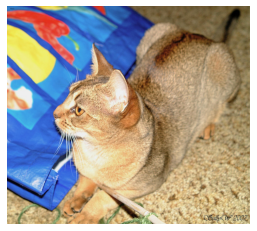

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

And here is its corresponding target:

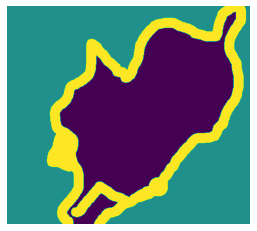

In [6]:
def display_target(target_array):
    # The original labels are 1, 2, and 3. We subtract 1 so that the labels range from 0 to 2, and then we multiply by 127 so that the labels become 0 (black), 127 (gray), 254 (near-white).
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

# We use color_mode="grayscale" so that the image we load is treated as having a single color channel.
img = img_to_array(load_img(target_paths[9], color_mode="grayscale")) 
display_target(img)

Next, let’s load our inputs and targets into two NumPy arrays, and let’s split the arrays into a training and a validation set. Since the dataset is very small, we can just load everything into memory:

In [8]:
import numpy as np
import random

img_size = (200, 200) # We resize everything to 200x200 pixels.
num_imgs = len(input_img_paths) # Total number of samples in the data.

# Shuffle the file paths (they were originally sorted by breed). 
# We use the same seed (1337) in both statements to ensure that the input paths and target paths stay in the same order.
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1 # Subtract 1 so that our labels become 0, 1 and 2.
    return img

# Load all images in the input_imgs float32 array and their masks in the targets uint8 array (same order). 
# The inputs have three channels (RBG values) and the targets have a single channel (which contains integer labels).
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

# Reserve 1,000 samples for validation.
num_val_samples = 1000
# Split the data into training and validation sets.
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

Now it’s time to define our model:

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs) # Don't forget to rescale input images to the [0-1] range.

    # Note how we use padding="same" everywhere to avoid the influence of border padding on feature map size.
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    # We end the model with a per-pixel three-way softmax to classify each output pixel into one of our three categories.
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

- The first half of the model closely resembles the kind of convnet you’d use for image classification: a stack of **Conv2D** layers, with gradually increasing filter sizes. We downsample our images three times by a factor of two each, ending up with activations of size (25, 25, 256). 
  - **The purpose of this first half is to encode the images into smaller feature maps, where each spatial location (or pixel) contains information about a large spatial chunk of the original image.** 
  - You can understand it as a kind of compression.
- One important difference between the first half of this model and the classification models you’ve seen before is the way we do **downsampling**: 
  - in the **classification convnets** from the last chapter, we used **MaxPooling2D** layers to downsample feature maps. 
  - Here, we downsample by adding **strides** to every other convolution layer (if you don’t remember the details of how convolution strides work, see “Understanding convolution strides” in section 8.1.1). 
    - We do this because, in the case of **image segmentation, we care a lot about the spatial location of information in the image**, since we need to produce per-pixel target masks as output of the model. 
    - When you do 2 × 2 **max pooling**, you are **completely destroying location information within each pooling window**: you return one scalar value per window, with zero knowledge of which of the four locations in the windows the value came from. 
  - So while **max pooling layers perform well for classification tasks**, they would hurt us quite a bit for a **segmentation task**. 
  - Meanwhile, **strided convolutions** do a better job at downsampling feature maps while retaining location information. Throughout this book, you’ll notice that we tend to use **strides** instead of **max pooling** in any model that cares about **feature location**, such as the **generative models** in chapter 12.
- The second half of the model is a stack of **Conv2DTranspose** layers. 
  - What are those? Well, the output of the first half of the model is a feature map of shape (25, 25, 256), but we want our final output to have the same shape as the target masks, (200, 200, 3). 
  - Therefore, we need to apply a kind of inverse of the transformations we’ve applied so far—**something that will upsample the feature maps instead of downsampling them**. 
  - That’s the purpose of the **Conv2DTranspose** layer: you can think of it as a kind of **convolution layer that learns to upsample**. 
    - If you have an input of shape (100, 100, 64), and you run it through the layer **Conv2D**(128, 3, strides=2, padding="same"), you get an output of shape (50, 50, 128). 
    - If you run this output through the layer **Conv2DTranspose**( 64, 3, strides=2, padding="same"), you get back an output of shape (100, 100, 64), the same as the original. 
  - So after **compressing** our inputs into feature maps of shape (25, 25, 256) via a stack of **Conv2D** layers, we can simply apply the corresponding sequence of **Conv2DTranspose layers to get back to images of shape (200, 200, 3)**.

We can now compile and fit our model:

In [13]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=10,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/10
100/100 [==============================] - 953s 10s/step - loss: 0.8613 - val_loss: 0.8013
Epoch 2/10
100/100 [==============================] - 917s 9s/step - loss: 0.7783 - val_loss: 0.7446
Epoch 3/10
100/100 [==============================] - 934s 9s/step - loss: 0.7276 - val_loss: 0.6848
Epoch 4/10
100/100 [==============================] - 935s 9s/step - loss: 0.6808 - val_loss: 0.6239
Epoch 5/10
100/100 [==============================] - 912s 9s/step - loss: 0.6442 - val_loss: 0.6418
Epoch 6/10
100/100 [==============================] - 906s 9s/step - loss: 0.6111 - val_loss: 0.5433
Epoch 7/10
100/100 [==============================] - 939s 9s/step - loss: 0.5927 - val_loss: 0.5782
Epoch 8/10
100/100 [==============================] - 920s 9s/step - loss: 0.5763 - val_loss: 0.5325
Epoch 9/10
100/100 [==============================] - 938s 9s/step - loss: 0.5498 - val_loss: 0.5472
Epoch 10/10
100/100 [==============================] - 910s 9s/step - loss: 0.5314 - val_l

Let’s display our training and validation loss(see figure 9.5 for 50 epochs):

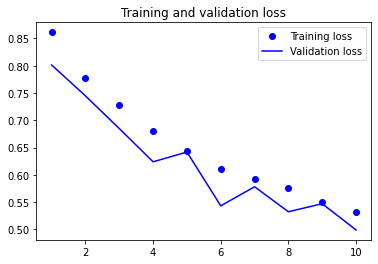

In [14]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

![](./chapter_images/9.5.png)

You can see that we start overfitting midway, around epoch 25. Let’s reload our best performing model according to the validation loss, and demonstrate how to use it to predict a segmentation mask (see figure 9.6):

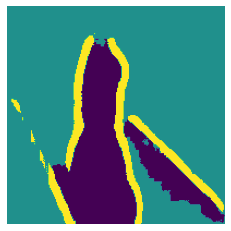

In [17]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

# Utility function to display a model's prediction.
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

![](./chapter_images/9.6.png)

There are a couple of small artifacts in our predicted mask, caused by geometric shapes in the foreground and background. Nevertheless, our model appears to work nicely. 
- By this point, throughout chapter 8 and the beginning of chapter 9, you’ve learned the basics of how to perform image classification and image segmentation: you can already accomplish a lot with what you know. 
- However, the convnets that experienced engineers develop to solve real-world problems aren’t quite as simple as those we’ve been using in our demonstrations so far. 
- You’re still lacking the essential mental models and thought processes that enable experts to make quick and accurate decisions about how to put together state-of-the-art models. 
- To bridge that gap, you need to learn about architecture patterns. 

Let’s dive in. --> part02_modern-convnet-architecture-patterns